# Build a model to classify topics for Telegram channels

**Pre-req**
1. Download csv from gdrive with channels and save to ``data/external/telegram_channels.csv``
2. Run ``python -m src.train.download`` to get posts and meta-data

**Steps**
1. Load data:
    - posts from channels
    - channel titles and descriptions
    - channel topics
2. Build a training dataset:
    1. Merge
    2. Select inputs
    3. Split into train/val
3. Build models:
    1. Embed text
    2. Train a classifier
    3. Select best
4. Evaluate on test data and save best

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
#standard libs
import os, sys
from pathlib import Path
from pprint import pprint
from collections import Counter
import random
import json
import itertools
from datetime import datetime as dt
# ds libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, tqdm_notebook

from torchtext import data
import re
# custom path
os.chdir('../..')
os.environ['KMP_DUPLICATE_LIB_OK']='True'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data prep

In [3]:
COMPLETIONS = [
    'data/raw/completions/project-1-at-2021-04-20-16-16-72cac916.json',
    'data/raw/completions/project-1-at-2021-04-21-17-06-382a61d8.json',
]

ACTIVE_COMPLETIONS = [
#     'data/external/2020-02-14_active_completions.json'
]


ONLY_PRIMARY = False
MIN_RAND = 2


### Compare raw tokens to lemmas

### Test data

In [184]:
def get_topics(value):
    """ return a list of topics from one string topic or multiple from a dict """
    if isinstance(value, dict):
        topics = value['choices']
    else:
        topics = [value] if value != '' else []
    return topics


def load_labelled_data(files):
    if len(files) == 0:
        return pd.DataFrame()
    labelled_data = [pd.read_json(c,) for c in files]
    labelled_data = pd.concat(labelled_data)
    labelled_data['secondary'].fillna('', inplace=True)
    labelled_data['primary'] = labelled_data['primary'].apply(get_topics)
    labelled_data['secondary'] = labelled_data['secondary'].apply(get_topics)
    labelled_data.drop(['annotator', 'annotation_id', 'title_display', 'description_display', 'recent_posts_display'], axis=1, inplace=True)
    labelled_data.info()
    return labelled_data


def prepare_labelled_data(labelled_data, weights=(1.0,0.5)):
    """ convert multiple labels to multiple rows """
    data = []
    p_w,s_w = weights
    for i, row in labelled_data.iterrows():
        for col in ['primary', 'secondary']:
            for top in row[col]:
                row['topic'] = top
                row['weight'] = p_w if col == 'primary' else s_w
                data.append(row)
    data = pd.DataFrame(data)
    return data

In [185]:
random_labels = load_labelled_data(COMPLETIONS)


random_labels.sample(4)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 168 entries, 0 to 157
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         168 non-null    object
 1   description   168 non-null    object
 2   subscribers   168 non-null    int64 
 3   counters      168 non-null    object
 4   recent_posts  168 non-null    object
 5   lang_code     168 non-null    object
 6   id            168 non-null    int64 
 7   primary       168 non-null    object
 8   secondary     168 non-null    object
dtypes: int64(2), object(7)
memory usage: 13.1+ KB


,title,description,subscribers,counters,recent_posts,lang_code,id,primary,secondary
125,مسلسلات ودراما عربية 2021,تحميل ومشاهدة المسلسلات العربية مجانا عبر قنا...,7130,"{'posts': 231, 'photos': 8, 'videos': 2, 'audi...","[{'type': 'text', 'text': '#رمضانك_عندنا متو...",ar,35,[Movies],[]
2,Марафон до 🍋,"💢Дарю VIP экспресс каждому бесплатно, пиши сюд...",10890,"{'posts': 2507, 'photos': 1805, 'videos': 12, ...","[{'type': 'photo', 'text': 'СТАВКА НА ФУТБОЛ🔥 ...",ru,189,[Bets & Gambling],[]
17,𝐖𝐈𝐍𝐍𝐈𝐍𝐆 𝐙𝐎𝐍𝐄,"Our free games win 98% , an absolute proof th...",4720,"{'posts': 21715, 'photos': 10204, 'videos': 37...","[{'type': 'text', 'text': 'If we send u 3.50 o...",en,172,[Bets & Gambling],[]
77,Фильмы | Сериалы,👤Реклама / Удаление @FI_TELEGA\n\n📧Почта: kino...,549780,"{'posts': 24, 'photos': 22, 'videos': 0, 'audi...","[{'type': 'photo', 'text': 'Отель Белград (202...",ru,95,[Movies],[]


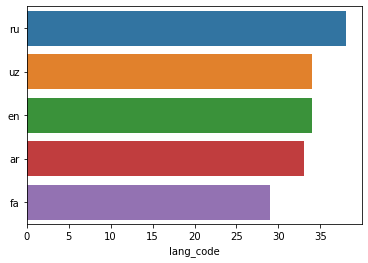

In [186]:
lang_counts = random_labels['lang_code'].value_counts()
sns.barplot(x=lang_counts, y=lang_counts.index);

In [187]:
test_data = prepare_labelled_data(random_labels)

test_data.shape

(226, 11)

### Topic distribution

In [188]:
from src.train.plot_utils import barplots

ru


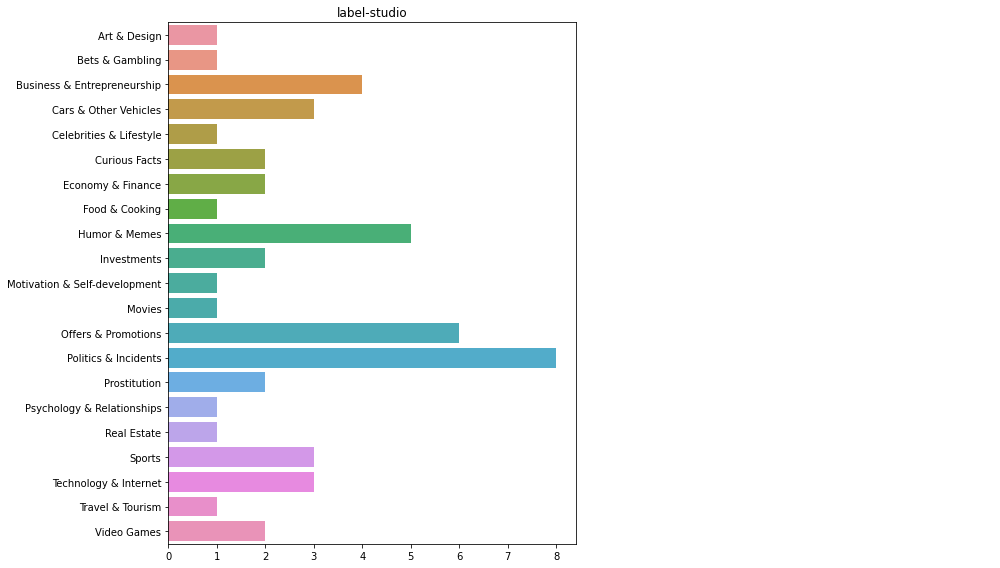

en


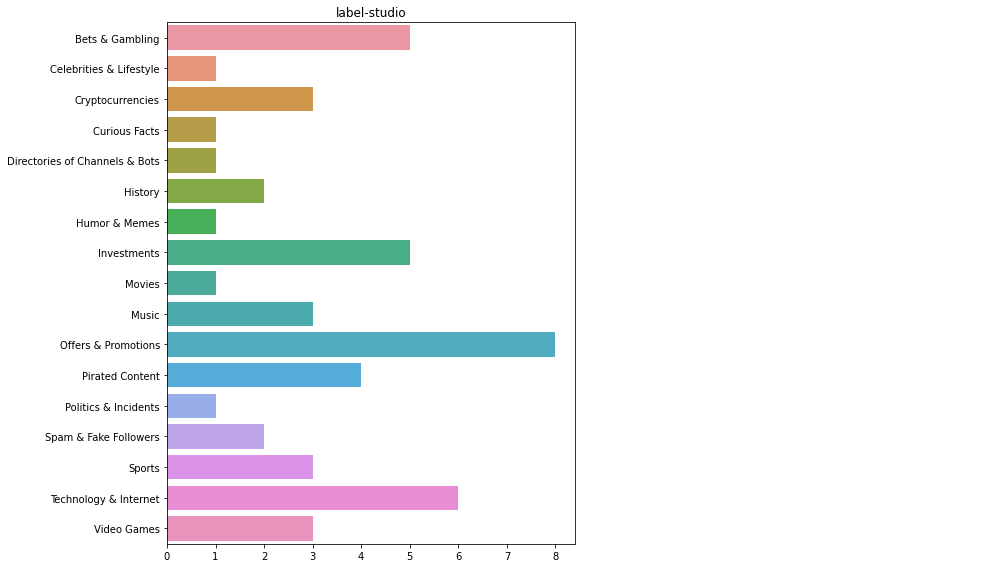

fa


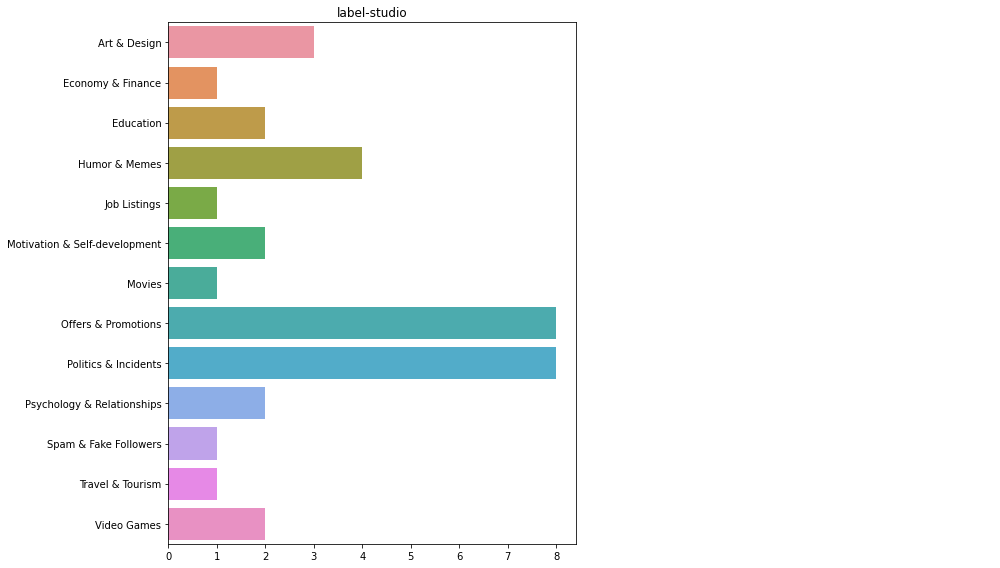

uz


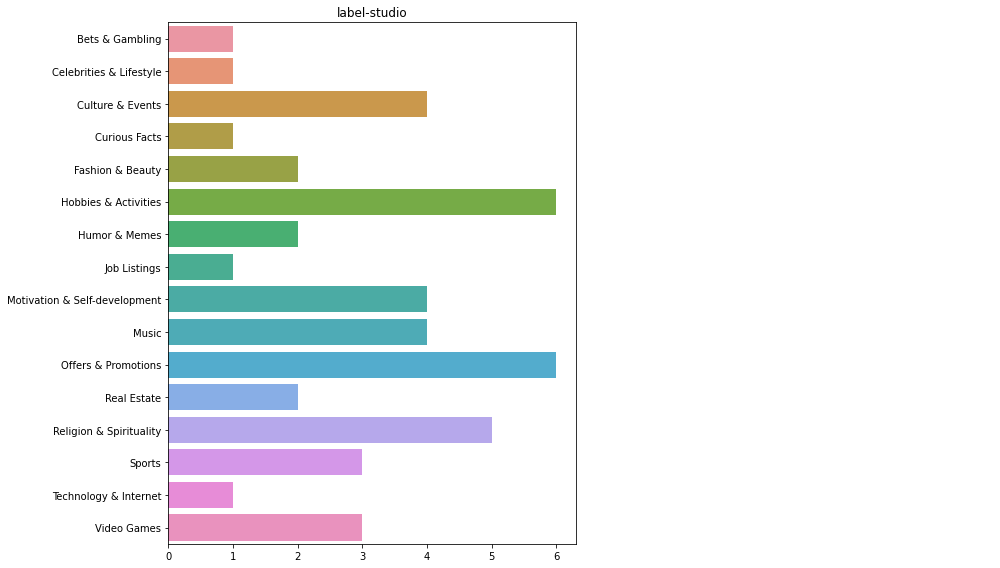

ar


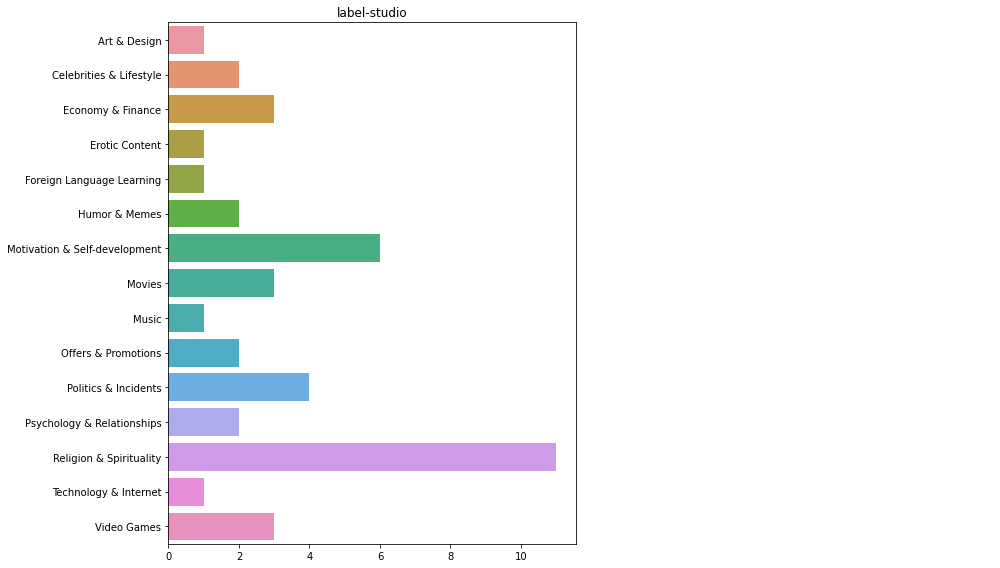

In [189]:
for l in test_data['lang_code'].unique():
    print(l)
    barplots({
        'label-studio': test_data.query(f"lang_code == '{l}'")['topic'],
    }, 1, 2, fig_dims=(14,8))

In [190]:
print(test_data.groupby('lang_code')['topic'].nunique())

lang_code
ar    15
en    17
fa    13
ru    21
uz    16
Name: topic, dtype: int64


### Save combined

In [191]:
comb = pd.concat([
#     inputs,
    test_data
], axis=0)
comb.shape

(226, 11)

In [192]:
comb.to_csv('data/interim/train_data.csv', index=False)

### Load stopwords

In [193]:
STOPWORDS = {
    'en': 'data/external/en_stopwords.txt',
    'ru': 'data/external/ru_stopwords.txt',
}

In [194]:
stopwords = [Path(f).read_text().strip().split('\n') for l,f in STOPWORDS.items()]

stopwords = sum(stopwords, [])

len(stopwords)

420

### Features

In [195]:
def prepare_text(row):
    """ extract and merge all text from a channel """
    post_texts = '\n'.join([post.get('text', "") for post in row['recent_posts']])
    merged = '\n'.join([row['title'], row['description'], post_texts])
    return merged

In [196]:
comb['text'] = comb.apply(prepare_text, axis=1)

## Experiments

**Hyper-parameters:**
- [x] topics: primary only, primary + secondary
- [x] inputs: title, description, posts
- [x] preprocessing: raw, lemmas
- [x] vectorizers: tf-idf, bow
- [x] clf: xgb, nb, etc.

In [197]:
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import ComplementNB, MultinomialNB

from xgboost import XGBClassifier

import itertools

In [198]:
from src.train.text_utils import tokenize_text

In [199]:
class Trainer:
    """ prapre inputs, vectorize texts and run a classifier """
    def __init__(self, lang_code, preprocessing, vect, est):
        self.LANG = lang_code
        self.data = comb.query(f"lang_code == '{lang_code}'")
        self.vect = VECTORIZERS[vect]
        self.vect.preprocessor = lambda x: x
        self.vect.lowercase = False
        self.clf = ESTIMATORS[est]
        assert preprocessing in ['lemma', 'raw']
        self.preprocessing = preprocessing
        if preprocessing == 'lemma':
            self.vect.tokenizer = lang_lemmatizer(lang_code)
        else:
            self.vect.tokenizer = tokenize_text
        
        
    def prepare_data(self, is_final):
        # text inputs and 
#         inputs['text'] = inputs.apply(lambda x: prepare_inputs(x, self.INPUT_FIELDS), axis=1)
#         test_data['text'] = test_data.apply(lambda x: prepare_inputs(x, self.INPUT_FIELDS), axis=1)
        # split into  train and test
#         test_subset = test_data.query(f"lang_code == '{self.LANG}'")
#         external_subset = inputs.query(f"lang_code == '{self.LANG}'")
        self.train_inputs,self.test_inputs = train_test_split(self.data, test_size=TEST_SIZE, random_state=24, shuffle=True,)
#         comb_datasets = [external_subset, one, self.test_inputs] if is_final else [external_subset, one]
#         self.train_inputs = pd.concat(one, axis=0)
        # x and y
        self.y_train = self.train_inputs['topic']
        self.y_test = self.test_inputs['topic']
        self.sample_weights = self.train_inputs['weight']
        self.X_train = self.vect.fit_transform(self.train_inputs['text'])
        self.X_test = self.vect.transform(self.test_inputs['text'])
        
        
    def run_eval(self, final=False):
        """ prepare inputs and run clf evaluation """
        self.prepare_data(final)
        # fit and eval
        self.clf.fit(self.X_train, self.y_train, sample_weight=self.sample_weights)
        self.predictions = pd.DataFrame({
                    'true': trainer.test_inputs['primary'],
                    'predicted': trainer.clf.predict(trainer.X_test)
                })
        score = self.predictions.apply(lambda x: x['predicted'] in x['true'], axis=1).mean()
        return score

### Set hyper-parameters

In [200]:
TEST_SIZE = 0.1

In [201]:
PREPROCESSING = [
    'raw',
#     'lemma',
]

vect_params = dict(
    max_df=0.4, 
    min_df=3,
    max_features=1000,
    binary=False, 
    ngram_range=(1,1), 
    tokenizer=tokenize_text,
    stop_words=stopwords, 
)
VECTORIZERS = {
    'tfidf': TfidfVectorizer(**vect_params),
    'bow': CountVectorizer(**vect_params),
}


ESTIMATORS = dict(
#     xgb = XGBClassifier(objective='multi:softmax'),
#     forest = RandomForestClassifier(),
#     logreg = LogisticRegression(),
#     knn = KNeighborsClassifier(),
#     tree = ExtraTreeClassifier(),
#     svm = SVC(),
#     linsvm = LinearSVC(),
    cnb = ComplementNB(),
    mnb = MultinomialNB(),
)

In [202]:

train_params = list(itertools.product(test_data['lang_code'].unique(), 
                                      PREPROCESSING,
                                VECTORIZERS.keys(), 
                                ESTIMATORS.keys()))

len(train_params)

20

### Run experiments

In [203]:
results = []

for params in tqdm_notebook(train_params, desc='# experiments'):
    trainer = Trainer(*params)
    score = trainer.run_eval()
    params += (score,)
    results.append(params)
                
results = pd.DataFrame(results, columns=['lang_code','preprocessing','vect', 'est', 'score'])

/Users/rustem.galiullin/miniconda3/envs/tgcat/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


# experiments:   0%|          | 0/20 [00:00<?, ?it/s]

/Users/rustem.galiullin/miniconda3/envs/tgcat/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:391: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['cent', 'dr', 'mr', 'per'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/rustem.galiullin/miniconda3/envs/tgcat/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:391: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['cent', 'dr', 'mr', 'per'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [204]:
for l in results['lang_code'].unique():
    print(results.query(f'lang_code == "{l}"').sort_values('score', ascending=False).to_markdown(), end='\n\n')

|    | lang_code   | preprocessing   | vect   | est   |    score |
|---:|:------------|:----------------|:-------|:------|---------:|
|  0 | ru          | raw             | tfidf  | cnb   | 0.166667 |
|  2 | ru          | raw             | bow    | cnb   | 0.166667 |
|  1 | ru          | raw             | tfidf  | mnb   | 0        |
|  3 | ru          | raw             | bow    | mnb   | 0        |

|    | lang_code   | preprocessing   | vect   | est   |   score |
|---:|:------------|:----------------|:-------|:------|--------:|
|  4 | en          | raw             | tfidf  | cnb   |     0.4 |
|  6 | en          | raw             | bow    | cnb   |     0.4 |
|  7 | en          | raw             | bow    | mnb   |     0.4 |
|  5 | en          | raw             | tfidf  | mnb   |     0.2 |

|    | lang_code   | preprocessing   | vect   | est   |   score |
|---:|:------------|:----------------|:-------|:------|--------:|
| 11 | fa          | raw             | bow    | mnb   |    0.25 |
| 

### Review errors

In [205]:
from sklearn.metrics import top_k_accuracy_score

#### Train

In [169]:
trainer = Trainer(
    lang_code = 'ru', 
    preprocessing = 'raw',
    vect = 'tfidf', 
    est = 'cnb'
)
s = trainer.run_eval(final=False)
print(s)

0.4


In [170]:
for k in [1,2,3,5]:
    top_k_acc = top_k_accuracy_score(trainer.y_test, trainer.clf.predict_proba(trainer.X_test), 
                                     labels=trainer.clf.classes_,
                                        k=k)
    print(f'Top {k} accuracy: {top_k_acc:.2f}', )

Top 1 accuracy: 1.00
Top 2 accuracy: 1.00
Top 3 accuracy: 1.00
Top 5 accuracy: 1.00


#### Classification report

In [144]:
from sklearn.metrics import classification_report

In [145]:
test_pred = trainer.clf.predict(trainer.X_test)

is_wrong = test_pred != trainer.y_test

errors = trainer.test_inputs[is_wrong]

errors['predicted'] = test_pred[is_wrong]

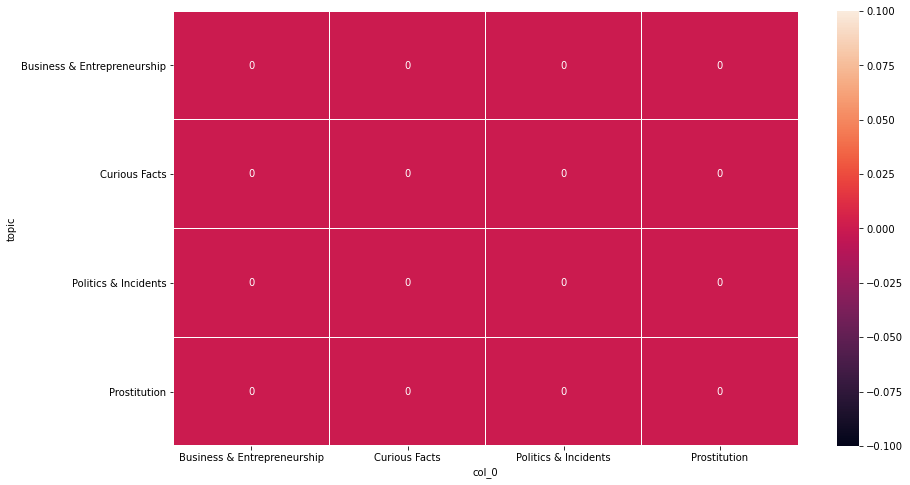

In [146]:
ct = pd.crosstab(trainer.y_test, test_pred)
for i,k in ct.iteritems():
    k[i] = 0


plt.figure(figsize=(14,8))
sns.heatmap(ct, annot=True, linewidths=0.01);

In [147]:
metrics = pd.DataFrame(classification_report(trainer.y_test, test_pred, output_dict=True, zero_division=0)).T

metrics = metrics.query("support > 0").sort_values('f1-score', ascending=True)

print(metrics.to_markdown())

|                             |   precision |   recall |   f1-score |   support |
|:----------------------------|------------:|---------:|-----------:|----------:|
| Business & Entrepreneurship |           1 |        1 |          1 |         2 |
| Curious Facts               |           1 |        1 |          1 |         1 |
| Politics & Incidents        |           1 |        1 |          1 |         1 |
| Prostitution                |           1 |        1 |          1 |         1 |
| accuracy                    |           1 |        1 |          1 |         1 |
| macro avg                   |           1 |        1 |          1 |         5 |
| weighted avg                |           1 |        1 |          1 |         5 |


#### random examples

In [150]:
row = errors.sample(1).iloc[0]

print('PREDICTED:\n', row['predicted'], end='\n\n')
print('TRUE:\n', row['primary'], end='\n\n')
print('TEXTS:\n', row['text'], end='\n\n')
print(f'TITLE ({row["id"]}):\n', row['title'], end='\n\n')
print('DESCRIPTION:\n', row['description'], end='\n\n')

ValueError: a must be greater than 0 unless no samples are taken

> /Users/rustem.galiullin/Personal/libtgcat/mtrand.pyx(903)numpy.random.mtrand.RandomState.choice()

ipdb> q


In [151]:
def get_topic_features(nb_clf, class_label, top_n=15):
    """ get features with largest log prob for the given class """
    class_i = np.argwhere(nb_clf.classes_ == class_label).squeeze()
    class_coef = nb_clf.feature_log_prob_[class_i]
    top_inds = np.argsort(class_coef)[-top_n:]
    return top_inds

In [152]:
FEATURES = trainer.vect.get_feature_names()
PREDICTED_INDEX = np.argwhere(trainer.clf.classes_ == row['predicted']).squeeze()

# get top features that triggered prediction
x = trainer.vect.transform([row['text']]).toarray()[0]
f = ( trainer.clf.feature_log_prob_ * x.T)[PREDICTED_INDEX]
top_keywords = [FEATURES[i] for i in np.argsort(f)[::-1][:15]]


true_inds = get_topic_features(trainer.clf, row['topic'],)
true_keywords = [FEATURES[i] for i in true_inds]

predicted_inds = get_topic_features(trainer.clf, row['predicted'],)
predicted_keywords = [FEATURES[i] for i in predicted_inds]


print('TRUE CLASS: ', row['topic'])
print(true_keywords, end='\n\n')
print(f'PREDICTED CLASS: {row["predicted"]}')
print(predicted_keywords, end='\n\n')
print('EXAMPLE')
print(top_keywords)

NameError: name 'row' is not defined

> <ipython-input-152-a4474647cb07>(2)<module>()
      1 FEATURES = trainer.vect.get_feature_names()
----> 2 PREDICTED_INDEX = np.argwhere(trainer.clf.classes_ == row['predicted']).squeeze()
      3 
      4 # get top features that triggered prediction
      5 x = trainer.vect.transform([row['text']]).toarray()[0]

ipdb> q


#### Fixes

**fixes**
- [ ] update stopwords
- [x] lemmas
- [x] remove single char terms
- [x] compare feature keywords against topic keywords
- [x] multi-class problem
- [x] only eng and rus chars
- [x] measure accuracy with top N predictions
- [x] use full data to train last
- [ ] sample weights for secondary
- [ ] bow to torchscript
- [x] apply sum normalization only then min prob threshold
- [x] fix when nothing predicted (add zero vectors as Other)
- [x] remove URL for lang detection

## Save models

In [206]:
from torch import nn
import torch
from torch.nn import functional as F
from typing import Dict, List, Tuple

In [207]:
class NaiveBayes(nn.Module):
    """ Implement Multinomial and Complement NB inference """
    def __init__(self, nb, clf,):
        super().__init__()
        assert nb in ['cnb','mnb']
        self.nb = nb
        self.feature_log_prior = nn.Parameter(torch.tensor(clf.feature_log_prob_), requires_grad=False)
        self.class_log_prior = nn.Parameter(torch.tensor(clf.class_log_prior_), requires_grad=False)
        self.class_labels = clf.classes_.tolist()
        

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        jll = torch.matmul(x.double(), self.feature_log_prior.T)
        if self.nb == 'cnb':
            if self.class_log_prior.size(0) == 1:
                jll += self.class_log_prior
        else:
            jll += self.class_log_prior
        log_prob = torch.logsumexp(jll, dim=1)
        log_prob = jll - torch.atleast_2d(log_prob).T
        prob = torch.exp(log_prob)
        return prob


class TextVectorizer(nn.Module):
    """ vectorize text using tf-idf or bow """
    def __init__(self, vect, vectorizer):
        super().__init__()
        assert vect in ['bow','tfidf']
        self.vocab = {k: torch.tensor(v) for k,v in vectorizer.vocabulary_.items()}
        self.vocab_len = len(self.vocab)
        if vect == 'tfidf':
            self.idf_diag = nn.Parameter(
                torch.tensor(vectorizer._tfidf._idf_diag.toarray()), 
                requires_grad=False)
            self.sublinear_tf = vectorizer.sublinear_tf
            self.norm = vectorizer.norm
            self.use_idf = vectorizer.use_idf
        else:
            self.idf_diag = nn.Parameter(torch.eye(self.vocab_len))
            self.sublinear_tf = False
            self.norm = None
            self.use_idf = False
            
        

    def count_vocab(self, doc: List[str]) -> torch.Tensor:
        """ return counts of each word from the vocab """
        feature_counter = torch.zeros(self.vocab_len, dtype=torch.long)
        for feature in doc:
            n = self.vocab.get(str(feature), torch.tensor(-1))
            if n.item() != -1:
                feature_idx = self.vocab[str(feature)]
                feature_counter[feature_idx] += 1
        return feature_counter
        
        
    def forward(self, batch: List[List[str]]) -> torch.Tensor:
        doc_counts: List[torch.Tensor] = [self.count_vocab(doc) for doc in batch]
        X = torch.stack(doc_counts,)
        if self.sublinear_tf:
            X = torch.log(X.double())
            X += 1
        if self.use_idf:
            X = torch.matmul(X.double(), self.idf_diag)
        if self.norm is not None:
            p = float(self.norm[-1])
            X = F.normalize(X.double(), p=p, dim=1)
        return X
    

class TgCat(nn.Module):
    """ vectorize input texts, classfy topics and decode predictions """
    def __init__(self, vect, clf, top_k=3,):
        super().__init__()
        self.vect = vect
        self.clf = clf
        self.top_k = top_k
        
        
    def select_top_classes(self, probs: torch.Tensor) -> Dict[str,float]:
        """ select classes with at least min prob and return a normalized dict mapping """
        if self.clf.nb == 'cnb':
            if probs.std(0) < 0.0001:
                return {"Other": 1.0}
        else:
            if probs.max() < 0.1:
                return {"Other": 1.0}
        inds_desc = torch.argsort(probs, 0, descending=True)
        top_k = min((probs > probs.mean()).sum(), torch.tensor(self.top_k))
        target_i = inds_desc[:top_k]
        target_p = probs[target_i]
        target_p = target_p / target_p.sum()
        result: List[Tuple[str, float]] = [
            (self.clf.class_labels[target_i[i].item()], target_p[i].item())
            for i in range(target_p.size(0))
        ]
        return dict(result)
    
    
    def get_prob(self, batch: List[List[str]]) -> torch.Tensor:
        embeddings = self.vect(batch)
        probs = self.clf(embeddings)
        return probs
        
    
    def forward(self, batch: List[List[str]]) -> List[Dict[str, float]]:
        probs = self.get_prob(batch)
        top_predictions = [self.select_top_classes(probs[i]) for i in range(probs.size(0))]
        return top_predictions

### Test

In [208]:
V = 'tfidf'
E = 'cnb'
L = 'en'

trainer = Trainer(
    lang_code = L, 
    preprocessing = 'raw',
    vect = V, 
    est = E,
)
_ = trainer.run_eval(final=False)

tgcat = TgCat(TextVectorizer(V, trainer.vect), NaiveBayes(E, trainer.clf), top_k=3)

In [209]:

batch = trainer.test_inputs['text'].apply(tokenize_text).tolist()

predictions = tgcat(batch)

In [210]:
v = tgcat.vect(batch)
p = tgcat.clf(v)

In [211]:
tgcat([['a','s','d'], [""], ["other", 'other', 'ttt'], ["чгк", "нияег", "его"]])

[{'Other': 1.0}, {'Other': 1.0}, {'Other': 1.0}, {'Other': 1.0}]

In [213]:
i = random.randint(0, len(batch) - 1)

print('PREDICTED', predictions[i], end='\n\n')
print('TOKENS', batch[i])

PREDICTED {'Offers & Promotions': 0.3450365632908583, 'Cryptocurrencies': 0.3315956702259165, 'Bets & Gambling': 0.3233677664832253}

TOKENS ['strategic', 'alphafocused', 'on', 'discovering', 'multibaggers', 'and', 'investing', 'in', 'them', 'inspired', 'by', 'buffet', 'lynch', 'and', 'pabrai', 'mr', 'suyog', 'dhavan', 'is', 'also', 'value', 'investing', 'and', 'value', 'trading', 'mentor', 'blog', 'strategicalpha', 'blogmany', 'uninformed', 'investors', 'and', 'and', 'non', 'diciplined', 'traders', 'will', 'be', 'washed', 'out', 'in', 'this', 'high', 'volatility', 'as', 'an', 'investor', 'buy', 'the', 'weakness', 'as', 'trader', 'buy', 'the', 'strength', 'registrants', 'are', 'seating', 'size', 'is', 'first', 'come', 'first', 'serve', 'appologies', 'from', 'us', 'in', 'advance', 'if', 'some', 'people', 'arent', 'able', 'to', 'attend', 'due', 'to', 'limited', 'seats', 'to', 'make', 'sure', 'you', 'are', 'in', 'by', 'joining', 'early', 'check', 'your', 'emails', 'for', 'the', 'link', 'w

### Final training, convert and save

In [161]:
from sklearn.preprocessing import normalize

In [179]:
prediction_params = {
    'top_k': 3
}

In [182]:
for l in results['lang_code'].unique():
    subset = results.query(f"lang_code == '{l}'")
    best_id = subset['score'].idxmax()
    best_params = subset.loc[best_id].to_dict()
    print(l, 'best', best_params)
    del best_params['score']
    # for last training increase train by test
    trainer = Trainer(**best_params)
    s = trainer.run_eval(final=True)
    print(l, s)
    # save text vectorizer
    vect_scripted = torch.jit.script(TextVectorizer(best_params['vect'], trainer.vect), )
    tokenizer = tokenize_text if best_params['preprocessing'] == 'raw' else lang_lemmatizer(l)
    batch = trainer.test_inputs['text'].apply(tokenizer).tolist()
    vect_out = vect_scripted(batch)
    src_vects = trainer.X_test.toarray()
    assert np.allclose(src_vects, vect_out.numpy())
    vect_scripted.save(f"models/trained/embed/{l}_{best_params['vect']}_script.pt")
    # save classifier
    nb_scripted  = torch.jit.script(NaiveBayes(best_params['est'], trainer.clf))
    nb_out = nb_scripted(torch.tensor(trainer.X_test.toarray(), dtype=torch.double))
    assert np.allclose(trainer.clf.predict_proba(trainer.X_test), nb_out.numpy())
    nb_scripted.save(f"models/trained/classify/{l}_{best_params['est']}_script.pt")
    # save tgcat
    tgcat = torch.jit.script(TgCat(vect_scripted, nb_scripted, **prediction_params))
    path = f'models/trained/tgcat/{l}_tgcat.pt'
    torch.jit.save(tgcat, path)
    print('saved to', path)

ru best {'lang_code': 'ru', 'preprocessing': 'raw', 'vect': 'tfidf', 'est': 'cnb', 'score': 0.4}
ru 0.4
saved to models/trained/tgcat/ru_tgcat.pt
en best {'lang_code': 'en', 'preprocessing': 'raw', 'vect': 'tfidf', 'est': 'cnb', 'score': 0.25}
en 0.25
saved to models/trained/tgcat/en_tgcat.pt
fa best {'lang_code': 'fa', 'preprocessing': 'raw', 'vect': 'tfidf', 'est': 'mnb', 'score': 0.3333333333333333}
fa 0.3333333333333333
saved to models/trained/tgcat/fa_tgcat.pt
ar best {'lang_code': 'ar', 'preprocessing': 'raw', 'vect': 'tfidf', 'est': 'cnb', 'score': 0.3333333333333333}
ar 0.3333333333333333
saved to models/trained/tgcat/ar_tgcat.pt
uz best {'lang_code': 'uz', 'preprocessing': 'raw', 'vect': 'tfidf', 'est': 'cnb', 'score': 0.0}
uz 0.0
saved to models/trained/tgcat/uz_tgcat.pt


### Check file sizes

In [183]:
!du -hm models/trained/*/* | sort -nr

17	models/trained/embed/ru_bow_script.pt
17	models/trained/embed/en_bow_script.pt
3	models/trained/tgcat/ru_tgcat.pt
3	models/trained/embed/ru_tfidf_script.pt
2	models/trained/tgcat/fa_tgcat.pt
2	models/trained/embed/fa_tfidf_script.pt
1	models/trained/tgcat/uz_tgcat.pt
1	models/trained/tgcat/en_tgcat.pt
1	models/trained/tgcat/ar_tgcat.pt
1	models/trained/embed/uz_tfidf_script.pt
1	models/trained/embed/ru_bow.txt
1	models/trained/embed/en_tfidf_script.pt
1	models/trained/embed/ar_tfidf_script.pt
1	models/trained/classify/uz_cnb_script.pt
1	models/trained/classify/ru_mnb_script.pt
1	models/trained/classify/ru_cnb_script.pt
1	models/trained/classify/fa_mnb_script.pt
1	models/trained/classify/en_cnb_script.pt
1	models/trained/classify/ar_cnb_script.pt
